--- 포트폴리오 백테스팅 (리밸런싱 적용) 시뮬레이션 시작 ---

--- Daily (Max Sharpe) 모델 시뮬레이션 시작 ---


C:\Users\012oov\AppData\Local\Temp\ipykernel_18904\1796838096.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


Total rebalances: 2
  - 최종 가치: $137,105,686.14, CAGR: 4.20%, MDD: -9.47%, Sharpe: 1.14

--- Weekly (Max Sharpe) 모델 시뮬레이션 시작 ---


C:\Users\012oov\AppData\Local\Temp\ipykernel_18904\1796838096.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


Total rebalances: 2
  - 최종 가치: $134,684,500.24, CAGR: 3.96%, MDD: -9.20%, Sharpe: 1.23

--- Monthly (Max Sharpe) 모델 시뮬레이션 시작 ---
Total rebalances: 2


C:\Users\012oov\AppData\Local\Temp\ipykernel_18904\1796838096.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


  - 최종 가치: $138,562,053.02, CAGR: 4.35%, MDD: -6.96%, Sharpe: 1.37

--- Risk Parity 모델 시뮬레이션 시작 ---
Total rebalances: 2


C:\Users\012oov\AppData\Local\Temp\ipykernel_18904\1796838096.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


  - 최종 가치: $168,273,506.87, CAGR: 7.02%, MDD: -15.91%, Sharpe: 0.97

--- Daily (30% Cap) 모델 시뮬레이션 시작 ---
Total rebalances: 6


C:\Users\012oov\AppData\Local\Temp\ipykernel_18904\1796838096.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


  - 최종 가치: $293,643,442.66, CAGR: 15.09%, MDD: -26.15%, Sharpe: 1.23

--- Minimum Variance 모델 시뮬레이션 시작 ---
Total rebalances: 0


C:\Users\012oov\AppData\Local\Temp\ipykernel_18904\1796838096.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


  - 최종 가치: $116,082,341.38, CAGR: 1.96%, MDD: -5.39%, Sharpe: 1.18

--- Target Return (18%) 모델 시뮬레이션 시작 ---
Total rebalances: 10


C:\Users\012oov\AppData\Local\Temp\ipykernel_18904\1796838096.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


  - 최종 가치: $412,648,785.14, CAGR: 20.31%, MDD: -33.17%, Sharpe: 1.28


C:\Users\012oov\AppData\Local\Temp\ipykernel_18904\1796838096.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(portfolio_results))


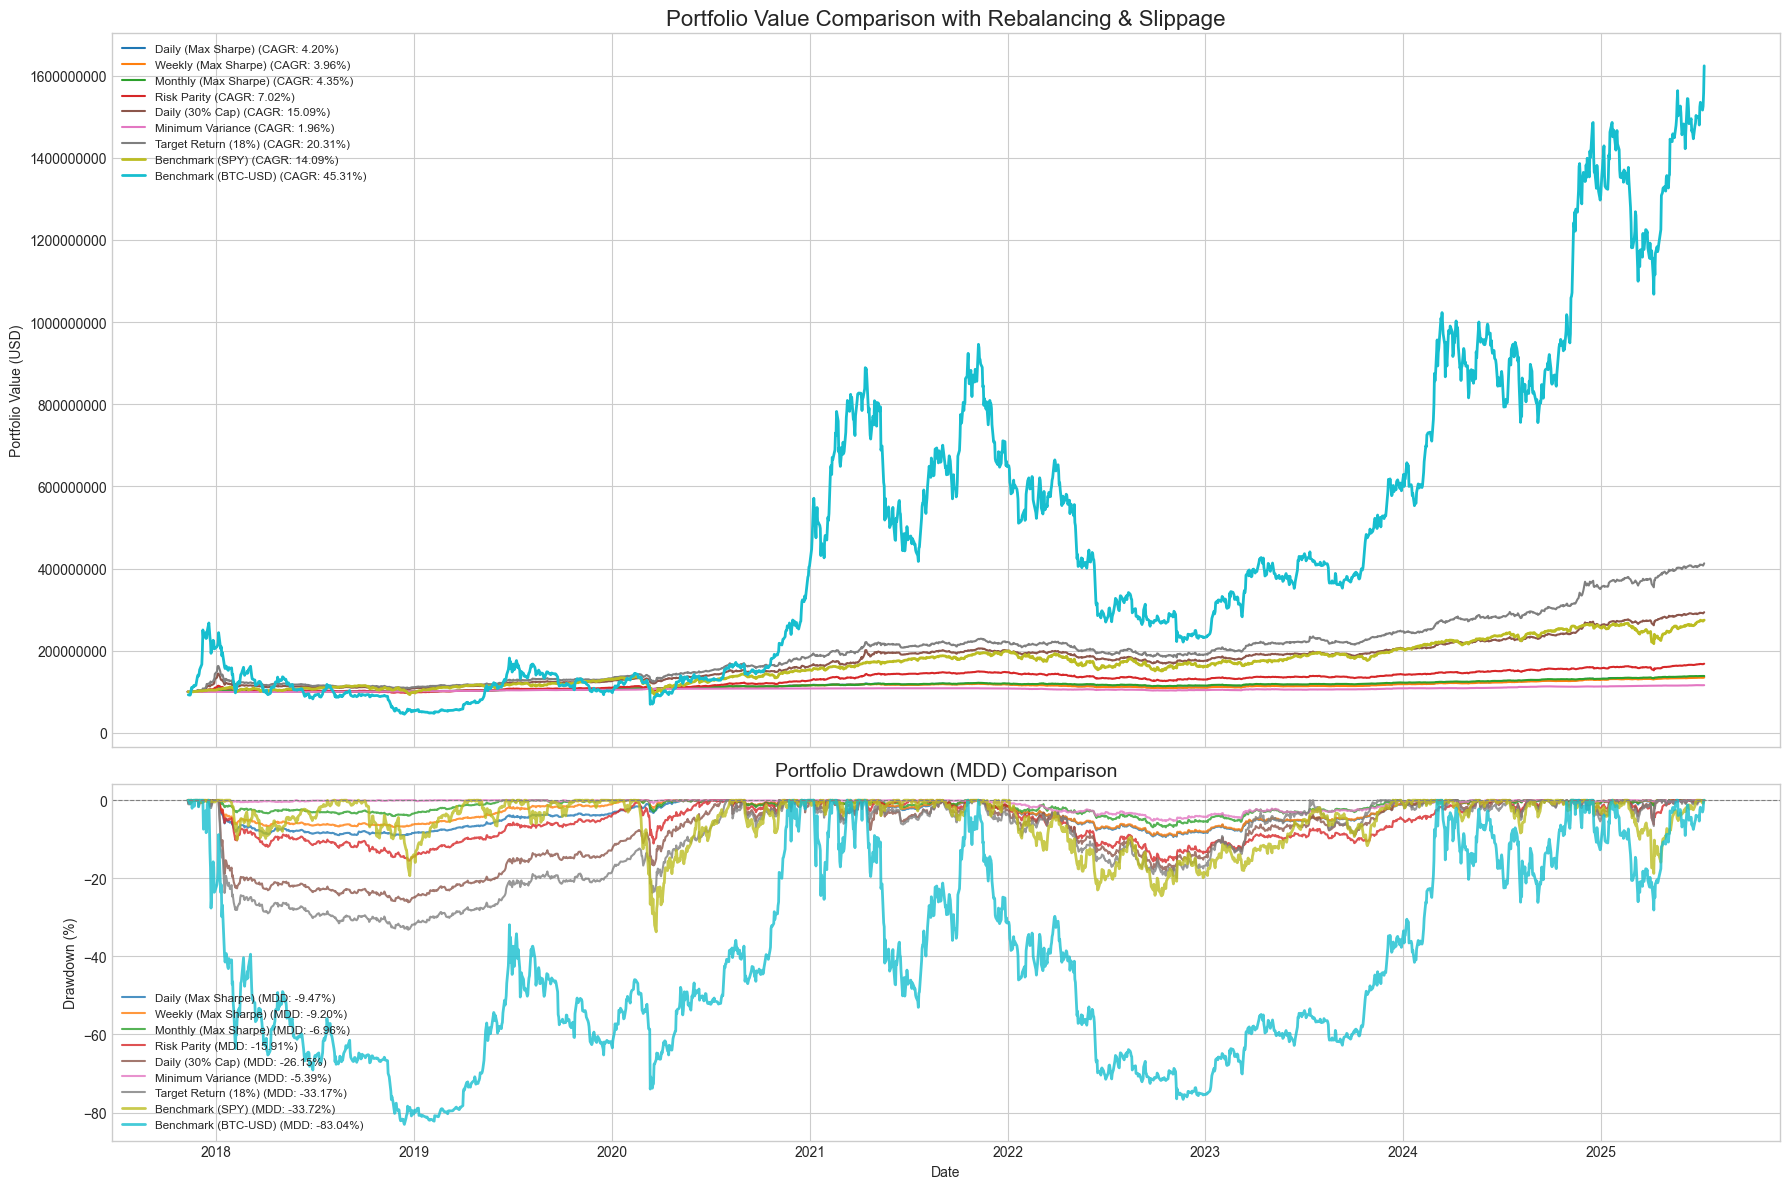

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# --- 경로 설정 (상대 경로 방식으로 변경) ---
try:
    MAIN_DIR = Path(__file__).resolve().parent
except NameError:
    MAIN_DIR = Path.cwd()

DATA_DIR = MAIN_DIR / "Data"
RESULTS_DIR = MAIN_DIR / "Results"

DOWNLOADED_DATA_PATH = DATA_DIR / "Raw data" / "downloaded_stock_prices.csv"
OPTIMIZED_WEIGHTS_EXCEL_PATH = RESULTS_DIR / "optimized_weights_all_periods.xlsx"

# --- 시뮬레이션 상세 설정 ---
INITIAL_INVESTMENT_USD = 100_000_000
RISK_FREE_RATE_ANNUAL = 0.00
SLIPPAGE_PCT = 0.001  # 0.1%의 거래비용(슬리피지)
REBALANCING_FREQUENCY = 'M' # 'M': 월별, 'Q': 분기별로 리밸런싱 여부 체크
REBALANCING_THRESHOLD = 0.05 # 목표 비중에서 5% 이상 벗어나면 리밸런싱 실행

def run_rebalancing_simulation(prices_df, target_weights, initial_investment, frequency, threshold, slippage):
    """
    리밸런싱과 슬리피지를 적용하여 포트폴리오 가치를 시뮬레이션합니다.
    """
    # target_weights를 pandas Series로 변환 (인덱스 정렬을 위해)
    target_weights = pd.Series(target_weights, index=prices_df.columns)
    
    # 포트폴리오 로그 데이터프레임 초기화
    portfolio_log = pd.DataFrame(index=prices_df.index, columns=['total_value'] + list(prices_df.columns))
    
    # 첫 날 포트폴리오 설정
    initial_asset_values = initial_investment * target_weights
    portfolio_log.iloc[0] = [initial_investment] + list(initial_asset_values)
    
    # 리밸런싱 체크 날짜 생성
    rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)

    rebalance_count = 0

    # 날짜를 순회하며 시뮬레이션
    for i in range(1, len(prices_df)):
        prev_date = prices_df.index[i-1]
        curr_date = prices_df.index[i]
        
        # 자산 가치 업데이트 (일별 수익률 반영)
        daily_returns = prices_df.loc[curr_date] / prices_df.loc[prev_date]
        current_asset_values = portfolio_log.loc[prev_date, prices_df.columns] * daily_returns
        current_total_value = current_asset_values.sum()
        
        # 리밸런싱 체크 날짜인지 확인
        if curr_date in rebal_check_dates:
            current_weights = current_asset_values / current_total_value
            deviation = np.abs(current_weights - target_weights).max()
            
            # 리밸런싱 조건 충족 시
            if deviation > threshold:
                rebalance_count += 1
                
                # 목표 자산 가치 계산
                target_asset_values = current_total_value * target_weights
                
                # 거래량 및 비용 계산
                turnover = np.abs(target_asset_values - current_asset_values).sum() / 2
                cost = turnover * slippage
                
                # 비용 차감 후 최종 포트폴리오 가치 및 자산 가치 업데이트
                final_total_value = current_total_value - cost
                current_asset_values = final_total_value * target_weights
                current_total_value = final_total_value

        # 포트폴리오 로그 기록
        portfolio_log.loc[curr_date, prices_df.columns] = current_asset_values
        portfolio_log.loc[curr_date, 'total_value'] = current_total_value
        
    print(f"Total rebalances: {rebalance_count}")
    return portfolio_log['total_value'].astype(float)

def calculate_mdd(portfolio_value_series):
    """포트폴리오 가치 시계열로부터 MDD (Maximum Drawdown)와 Drawdown 시계열을 계산합니다."""
    if portfolio_value_series.empty: return 0.0, None, None, pd.Series()
    peak = portfolio_value_series.expanding(min_periods=1).max()
    drawdown = (portfolio_value_series / peak) - 1.0
    mdd = drawdown.min()
    end_date = drawdown.idxmin()
    start_date = peak.loc[:end_date].idxmax()
    return mdd, start_date, end_date, drawdown

def calculate_cagr(portfolio_value_series):
    """포트폴리오 가치 시계열로부터 연평균 복합 성장률 (CAGR)을 계산합니다."""
    if portfolio_value_series.empty or len(portfolio_value_series) < 2: return 0.0
    total_years = (portfolio_value_series.index[-1] - portfolio_value_series.index[0]).days / 365.25
    if total_years <= 0: return 0.0
    return (portfolio_value_series.iloc[-1] / portfolio_value_series.iloc[0])**(1/total_years) - 1

def calculate_sharpe_ratio(portfolio_value_series, risk_free_rate_annual):
    """포트폴리오 가치 시계열을 기반으로 연간 샤프 비율을 계산합니다."""
    if portfolio_value_series.empty: return 0.0
    daily_returns = portfolio_value_series.pct_change().dropna()
    excess_daily_returns = daily_returns - ((1 + risk_free_rate_annual)**(1/252) - 1)
    annualized_excess_return = excess_daily_returns.mean() * 252
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    if annualized_volatility == 0: return np.inf if annualized_excess_return > 0 else 0.0
    return annualized_excess_return / annualized_volatility

def format_model_name(sheet_name):
    """Excel 시트 이름을 그래프에 표시할 예쁜 이름으로 변환합니다."""
    name = sheet_name.replace('_weights', '')
    if 'target_return' in name:
        rate = name.split('_')[-1]
        return f"Target Return ({rate}%)"
    name_map = {
        'daily': 'Daily (Max Sharpe)', 'weekly': 'Weekly (Max Sharpe)', 'monthly': 'Monthly (Max Sharpe)',
        'risk_parity': 'Risk Parity', 'daily_30_cap': 'Daily (30% Cap)', 'min_variance': 'Minimum Variance'
    }
    return name_map.get(name, name)

# --- 메인 실행 흐름 ---
if __name__ == "__main__":
    print("--- 포트폴리오 백테스팅 (리밸런싱 적용) 시뮬레이션 시작 ---")

    try:
        price_data = pd.read_csv(DOWNLOADED_DATA_PATH, index_col=0, parse_dates=True)
        all_weights_dict = pd.read_excel(OPTIMIZED_WEIGHTS_EXCEL_PATH, sheet_name=None)
    except FileNotFoundError as e:
        print(f"오류: 필수 파일 로드 실패 - {e}")
        exit()

    portfolio_results = {}
    
    # 1. 모든 최적화 모델 성과 계산
    for sheet_name, weights_df in all_weights_dict.items():
        model_name = format_model_name(sheet_name)
        print(f"\n--- {model_name} 모델 시뮬레이션 시작 ---")
        
        tickers = weights_df['Ticker'].tolist()
        weights = weights_df['Optimal_Weight'].values
        
        model_price_data = price_data[tickers].dropna()
        
        # 리밸런싱 시뮬레이션 실행
        portfolio_value = run_rebalancing_simulation(
            model_price_data, weights, INITIAL_INVESTMENT_USD, 
            REBALANCING_FREQUENCY, REBALANCING_THRESHOLD, SLIPPAGE_PCT
        )
        
        mdd, _, _, drawdown = calculate_mdd(portfolio_value)
        cagr = calculate_cagr(portfolio_value)
        sharpe = calculate_sharpe_ratio(portfolio_value, RISK_FREE_RATE_ANNUAL)
        
        portfolio_results[model_name] = {'value': portfolio_value, 'cagr': cagr, 'mdd': mdd, 'sharpe': sharpe, 'drawdown': drawdown}
        print(f"  - 최종 가치: ${portfolio_value.iloc[-1]:,.2f}, CAGR: {cagr*100:.2f}%, MDD: {mdd*100:.2f}%, Sharpe: {sharpe:.2f}")

    # 2. 벤치마크 성과 계산 (Buy and Hold)
    benchmarks = {'SPY': 'SPY', 'BTC-USD': 'BTC-USD'}
    for bm_name, bm_ticker in benchmarks.items():
        if bm_ticker in price_data.columns:
            bm_price_data = price_data[[bm_ticker]].dropna()
            # 벤치마크는 리밸런싱 없이 단순 계산
            bm_returns = bm_price_data.pct_change().dropna()
            bm_value = INITIAL_INVESTMENT_USD * (1 + bm_returns).cumprod()
            bm_value.columns = ['value']
            
            mdd, _, _, drawdown = calculate_mdd(bm_value['value'])
            cagr = calculate_cagr(bm_value['value'])
            sharpe = calculate_sharpe_ratio(bm_value['value'], RISK_FREE_RATE_ANNUAL)
            portfolio_results[f"Benchmark ({bm_name})"] = {'value': bm_value['value'], 'cagr': cagr, 'mdd': mdd, 'sharpe': sharpe, 'drawdown': drawdown}

    # 3. 시각화
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    colors = plt.cm.get_cmap('tab10', len(portfolio_results))
    
    # 포트폴리오 가치 추이
    for i, (name, data) in enumerate(portfolio_results.items()):
        ax1.plot(data['value'].index, data['value'], 
                 label=f"{name} (CAGR: {data['cagr']*100:.2f}%)", 
                 color=colors(i), linewidth=2 if 'Benchmark' in name else 1.5)
    
    ax1.set_title('Portfolio Value Comparison with Rebalancing & Slippage', fontsize=16)
    ax1.set_ylabel('Portfolio Value (USD)')
    ax1.legend(loc='upper left', fontsize='small')
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.grid(True)

    # MDD 추이
    for i, (name, data) in enumerate(portfolio_results.items()):
        ax2.plot(data['drawdown'].index, data['drawdown'] * 100,
                 label=f"{name} (MDD: {data['mdd']*100:.2f}%)",
                 color=colors(i), linewidth=2 if 'Benchmark' in name else 1.5, alpha=0.8)

    ax2.set_title('Portfolio Drawdown (MDD) Comparison', fontsize=14)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown (%)')
    ax2.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax2.legend(loc='lower left', fontsize='small')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
